In [1]:
# https://github.com/kwj2104/CPPN-WGAN

import torch
import torch.nn as nn
from torch.autograd import Variable as V
import matplotlib.pyplot as plt
import argparse
import matplotlib
# from pylab import savefig
import pylab

import numpy as np


In [23]:

parser = argparse.ArgumentParser(description='Create a Simple CPPN')

# Path Arguments
parser.add_argument('--random_seed', type=int, default=1, help='random seed')
parser.add_argument('--dim', type=int, default=500)
parser.add_argument('--cchannel', type=int, default=3)
parser.add_argument('--scaling', type=int, default=8)
parser.add_argument('--layer_size', type=int, default=32)

# args = parser.parse_args()
args = parser.parse_known_args()[0]

np.random.seed(args.random_seed)
torch.manual_seed(args.random_seed)


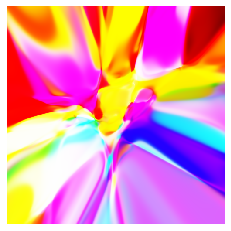

In [26]:
class CPPN(nn.Module):
    def __init__(self, x_dim, y_dim, batch_size=1, z_dim = 32, c_dim = 1, scale = 1.0, net_size = 32):
        super(CPPN, self).__init__()
        self.batch_size = batch_size
        self.net_size = net_size
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.scale = scale
        self.c_dim = c_dim
        self.z_dim = z_dim
        
        #Build NN graph
        self.linear1 = nn.Linear(z_dim, self.net_size)
        self.linear2 = nn.Linear(1, self.net_size, bias=False)
        self.linear3 = nn.Linear(1, self.net_size, bias=False)
        self.linear4 = nn.Linear(1, self.net_size, bias=False)
        
        self.linear5 = nn.Linear(self.net_size, self.net_size)
        self.linear6 = nn.Linear(self.net_size, self.net_size)
        self.linear7 = nn.Linear(self.net_size, self.net_size)
        
        self.linear8 = nn.Linear(self.net_size, self.c_dim)
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        self.lin_seq = nn.Sequential(self.tanh, self.linear5, self.tanh, self.linear6, self.tanh,
                                 self.linear7, self.tanh, self.linear8, self.sigmoid)
        
        
        lin_list = [self.linear1, self.linear2, self.linear3, self.linear4, self.linear5, self.linear6, 
                    self.linear7, self.linear8]
        
        for layer in lin_list:
            layer.weight.data.normal_(0, 1)
            try:
                layer.bias.data.fill_(0)
            except:
                pass
        
    
    def forward(self, x, y, r):
        
        z = np.random.uniform(-1.0, 1.0, size=(1, self.z_dim)).astype(np.float32)
        z_scaled = V(torch.from_numpy(np.matmul(np.ones((self.x_dim*self.y_dim, 1)), z)).float())
        
        U = self.linear1(z_scaled) + self.linear2(x) + self.linear3(y) + self.linear4(r)   
        
        result = self.lin_seq(U)
        
        return result
    
def get_coordinates(x_dim = 32, y_dim = 32, scale = 10.0, batch_size = 1):
#     calculates and returns a vector of x and y coordintes, and corresponding radius from the centre of image.
    n_points = x_dim * y_dim
    
    # creates a list of x_dim values ranging from -1 to 1, then scales them by scale
    x_range = scale*(np.arange(x_dim)-(x_dim-1)/2.0)/(x_dim-1)/0.5
    y_range = scale*(np.arange(y_dim)-(y_dim-1)/2.0)/(y_dim-1)/0.5        
    x_mat = np.matmul(np.ones((y_dim, 1)), x_range.reshape((1, x_dim)))
    y_mat = np.matmul(y_range.reshape((y_dim, 1)), np.ones((1, x_dim)))
    r_mat = np.sqrt(x_mat*x_mat + y_mat*y_mat)
    x_mat = np.tile(x_mat.flatten(), batch_size).reshape(batch_size, n_points, 1)
    y_mat = np.tile(y_mat.flatten(), batch_size).reshape(batch_size, n_points, 1)
    r_mat = np.tile(r_mat.flatten(), batch_size).reshape(batch_size, n_points, 1)
    return torch.from_numpy(x_mat).float(), torch.from_numpy(y_mat).float(), torch.from_numpy(r_mat).float()
         
def save_image(image_data, c_dim = 1):
#     image_data is a tensor, in [height width depth]
#     image_data is NOT the PIL.Image class
    plt.subplot(1, 1, 1)
    y_dim = image_data.shape[0]
    x_dim = image_data.shape[1]
    if c_dim > 1:
      plt.imshow(image_data, interpolation='nearest')
    else:
      plt.imshow(image_data.reshape(y_dim, x_dim), cmap='Greys', interpolation='nearest')
    plt.axis('off')
    ##plt.show()
    
    plt.gca().set_axis_off()
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.ticker.NullLocator())
    
    plt.savefig('CPPN/examplefig/figure_'
            + str(args.cchannel) + '_' 
            + str(args.random_seed) + '_' 
            + str(args.layer_size) + '.png', bbox_inches='tight', pad_inches=0.0)
    
if __name__ == "__main__":
    
#    print('examples/figure_' + str(args.cchannel))
#    raise Exception()
    
    model = CPPN(x_dim = args.dim, y_dim = args.dim, c_dim = args.cchannel, net_size = args.layer_size)
    x, y, r = get_coordinates(x_dim = args.dim, y_dim = args.dim, scale = args.scaling)   
    result = model.forward(x, y, r).squeeze(0).view(args.dim, args.dim, args.cchannel).data.numpy()
    
    save_image(result, c_dim = args.cchannel)